# PyEumap - Land Cover Mapping (Advanced)

In this tutorial we improve the land cover mapping generating **probability** and **uncertantity** output per class, as well as an **[Ensemble Machine Learning](https://machinelearningmastery.com/what-is-ensemble-learning/)** approach and a **hyperparameter optimization** guided by the **[log_loss metric](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)**, suitable for this kind of output. Before continue, please, first execute the [Overlay](02_overlay.ipynb) and the [Land-Cover Mapping](03_landcover_mapping.ipynb) tutorials for the same tile.

This tutorial will map the follow land cover classes using the same covariates provided by the past tutorials:
* 231: Pastures,
* 312: Coniferous forest,
* 321: Natural grasslands,
* 322: Moors and heathland,
* 324: Transitional woodland-shrub,
* 332: Bare rocks,
* 333: Sparsely vegetated areas,
* 335: Glaciers and perpetual snow.

First, let's import the necessary modules

In [1]:
import sys
sys.path.append('../../')

import os
import gdal
from pathlib import Path
import pandas as pd
import geopandas as gpd
from pyeumap.mapper import LandMapper

...and load the overlaid samples for a specific tile:

In [2]:
from pyeumap import datasets

# Tile definition
tile = datasets.TILES[0]
print(f'Tile: {tile}\n\n')

# Folder setup
data_root = datasets.DATA_ROOT_NAME
data_dir = Path(os.getcwd()).joinpath(data_root,tile)

# Reading the samples
fn_points = Path(os.getcwd()).joinpath(data_dir, tile + '_landcover_samples_overlayed.gpkg')
points = gpd.read_file(fn_points)
points.head()

Tile: 10636_switzerland




,lucas,survey_date,confidence,tile_id,lc_class,overlay_id,dtm_elevation,dtm_slope,landsat_ard_winter_green_p75,landsat_ard_spring_green_p75,...,landsat_ard_summer_thermal_p75,landsat_ard_winter_thermal_p50,landsat_ard_winter_blue_p25,landsat_ard_fall_thermal_p50,landsat_ard_summer_thermal_p50,landsat_ard_spring_blue_p50,landsat_ard_fall_blue_p25,landsat_ard_spring_blue_p25,landsat_ard_summer_blue_p50,geometry
0,False,2006-06-30T00:00:00,85,10636,321,1,1948.0,36.313705,148.0,19.0,...,183.0,176.0,128.0,185.0,183.0,11.0,5.0,11.0,8.0,POINT (4145221.759 2594636.440)
1,False,2006-06-30T00:00:00,85,10636,321,2,2209.0,7.917305,135.0,159.0,...,182.0,176.0,118.0,183.0,182.0,120.0,5.0,96.0,5.0,POINT (4142366.664 2598169.380)
2,False,2006-06-30T00:00:00,85,10636,321,3,1990.0,32.722038,142.0,19.0,...,185.0,179.0,100.0,187.0,185.0,10.0,4.0,10.0,9.0,POINT (4140249.007 2596954.755)
3,False,2006-06-30T00:00:00,85,10636,322,4,2142.0,49.800537,47.0,36.0,...,179.0,175.0,48.0,179.0,179.0,37.0,7.0,37.0,2.0,POINT (4148638.412 2595538.585)
4,False,2006-06-30T00:00:00,85,10636,332,5,2420.0,27.018671,233.0,221.0,...,188.0,178.0,228.0,188.0,188.0,201.0,16.0,184.0,16.0,POINT (4156286.754 2595790.720)


## Probability output

Considering that a probability output provides diferent levels of classification for the target classes, it's recommended a diferent evaluation metric for the the hyperparameter optimization. Here we choosen **[log_loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) (logistic loss or cross-entropy loss)**, however you can find more options in [scikit-learn - Classification Metrics](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) (hinge_loss, brier_score_loss).

Unlike the F1-Score, a lower log_loss is better for the optimization process, and because of that we will multiply by **-1** the returned function error.

In [4]:
from sklearn.metrics import log_loss

def log_loss_scorer(clf, X, y_true):
    class_labels = clf.classes_
    y_pred_proba = clf.predict_proba(X)
    error = log_loss(y_true, y_pred_proba, labels=class_labels)
    return error * -1

We will use the same classification algorithm, hyperparameter possibilities and cv strategy of the past tutorial:

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=100)

hyperpar = GridSearchCV(
    estimator = estimator,
    scoring = log_loss_scorer,
    param_grid = {
     'min_samples_leaf': [1, 5],
     'max_depth': [5, None], 
     'max_features': [0.5]
    }
)

Now let's create a new instance for the LandMapper class passing one aditional parameter:
* ***pred_method***: The predict_proba will change the model output for a lc-class probabilities.

In [6]:
feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'
weight_col = 'confidence'

min_samples_per_class = 0.05
cv = 5

landmapper_prob = LandMapper(points=points, 
                        feat_col_prfxs = feat_col_prfxs, 
                        target_col = target_col, 
                        estimator = estimator, 
                        hyperpar_selection = hyperpar,
                        cv = cv,
                        min_samples_per_class=min_samples_per_class,
                        pred_method='predict_proba',
                        weight_col=weight_col,
                        verbose = True)

[12:31:48] Removing 74 samples due min_samples_per_class condition (< 0.05)
[12:31:48] Transforming lc_class:
[12:31:48]  -Original classes: [231. 312. 321. 322. 324. 332. 333. 335.]
[12:31:48]  -Transformed classes: [0 1 2 3 4 5 6 7]


Notice that the **original classes** were remaped for a **sequential class values** using [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), which can be accessed in the property *target_le*:

In [7]:
landmapper_prob.target_le

LabelEncoder()

Time to run (*If it's taking too long try to reduce the hyperparameters possibilities and/or the cv=2*):

In [8]:
landmapper_prob.train()

[12:31:52] Optimizing hyperparameters for RandomForestClassifier
[12:32:15]  1.04427 (+/-0.07006) from {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 1}
[12:32:15]  1.04846 (+/-0.06574) from {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 5}
[12:32:15]  0.81058 (+/-0.17991) from {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1}
[12:32:15]  0.87219 (+/-0.08053) from {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 5}
[12:32:15] Best: -0.81058 using {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1}
[12:32:15] Calculating evaluation metrics


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[12:32:22] Training RandomForestClassifier using all samples


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.6s finished


Now let's take a look in the classification report.

In [10]:
print(f'Log loss: {landmapper_prob.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper_prob.eval_report)

Log loss: 0.838


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  0.8693     0.8311   0.3200        0.7273              0.7273         66
1  0.6378     0.7979   0.4400        0.7085              0.7121         199
2  0.8347     0.8021   0.3700        0.7590              0.7456         166
3  1.5644     0.5360   0.3000        0.5948              0.5798         116
4  1.6175     0.3801   0.2800        0.3690              0.3690         84
5  0.7146     0.7950   0.3700        0.7624              0.7549         101
6  0.5383     0.8817   0.4208        0.8166              0.8166         229
7  0.4921     0.9701   0.5000        0.9551              0.9551         89

Total                                                                     1050



Let's understand this report.

Using the cv result, the LandMapper calculated the **log_loss** and the **[pr_auc (area under the precision recall curve)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve)** for each class. The pr_auc information was used to choose the **best probability** value to derive a hard classification output, balancing the **precision** (*producer's accuracy or the class understimation*) and **recall** (*user's accuracy or the class overestimation*), thus minimizing the bias in the land cover area estimation. For more infomation about the precision recall curve [access this link](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/).

All the probabilities metrics are available through the ``prob_metrics`` property

In [9]:
list(landmapper_prob.prob_metrics.keys())

['log_loss',
 'pr_auc',
 'support',
 'opti_th',
 'opti_recall',
 'opti_precision',
 'curv_recall',
 'curv_precision',
 'curv_th']

...and it's possible to use the raw cv results to derive other evaluation metrics as [hinge_loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hinge_loss.html):

In [10]:
from sklearn import preprocessing, metrics

# Tranform the target classes in probability values
lb = preprocessing.LabelBinarizer()
targ_prob = lb.fit_transform(landmapper_prob.target)
n_classes = len(lb.classes_)

# Brier loss calculation for each class
print('Brier loss:')
for c in range(0,n_classes):
    brier_loss = metrics.brier_score_loss(targ_prob[:,c], landmapper_prob.eval_pred[:,c])
    print(f' - {lb.classes_[c]:.0f}: {brier_loss * 100:.3f}%')

Brier loss:
 - 0: 2.527%
 - 1: 7.172%
 - 2: 6.560%
 - 3: 6.711%
 - 4: 6.067%
 - 5: 3.512%
 - 6: 6.456%
 - 7: 0.709%


# EML (Emsemble Machine Learning) and uncertainties

Up until now only one estimator was used to produce the land cover maps. Even considering that the Random Forest is a emsemble of [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), the trees growth uses the same rationale to train a weak estimator considering different proportions of the full dataset ([Bagging approach](https://stats.stackexchange.com/a/19053)). A combination of the Random Forest with other estimators will produce multiple predicted values, produced by different approachs/algorithms that consequently splits the feature space in a diferent way, allowing the derivation of a final probability and a uncertanty estimative, based in the standard deviation of all predicted probabilties

To do it, let's first create our traditional estimator:

In [11]:
estimator_rf = RandomForestClassifier(n_jobs=-1, n_estimators=85)

hyperpar_rf = GridSearchCV(
    estimator = estimator_rf,
    scoring = log_loss_scorer,
    param_grid = {
     'max_depth': [5, None], 
     'max_features': [0.5, None]
    }
)

In addition to Random Forest we will use the [XGBoost](https://xgboost.readthedocs.io/en/latest/)

In [12]:
import xgboost as xgb
estimator_bgtree = xgb.XGBClassifier(n_jobs=-1, n_estimators=28, objective='multi:softmax', eval_metric='mlogloss', booster='gbtree')

hyperpar_bgtree = GridSearchCV(
    estimator = estimator_bgtree,
    scoring = log_loss_scorer,
    param_grid = {
     'eta': [0.001, 0.9], 
     'alpha': [0, 10]
    }
)

...and a regular ANN (Artificial Neural Network) through [KerasClassifier](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasClassifier):

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from pyeumap.misc import build_ann

input_shape = 87
n_classes = 8
estimator_ann = Pipeline([
	('standardize', StandardScaler()),
	('estimator', KerasClassifier(build_ann, input_shape=input_shape, output_shape=n_classes, \
		epochs=5, batch_size=64, learning_rate = 0.0005, \
		dropout_rate=0.15, n_layers = 4, n_neurons=64, shuffle=True, verbose=False))
])

hyperpar_ann = GridSearchCV(
    estimator = estimator_ann,
    scoring = log_loss_scorer,
    param_grid = {
     'estimator__dropout_rate': [0, 0.15], 
     'estimator__n_layers': [2, 4]
    }
)

It's important to choose modern estimators able to produce results **equally accurate** and **comparable** to the *Random Forest*, otherwise they could produce a poor classification results at end.

The three predicted probabilities will be combined by a meta-estimator, which will receive as **n_estimator * n_classes** covariates/features as input and produce the final output:

In [14]:
from sklearn.linear_model import LogisticRegression

meta_estimator = LogisticRegression(solver='saga', multi_class='multinomial')

hyperpar_meta = GridSearchCV(
    estimator = meta_estimator,
    scoring = log_loss_scorer,
    param_grid = {
        'fit_intercept': [False, True],
        'C': [0.5, 1]
    }
)

To pass the three estimators and their respective hyperparameter optimization critereas we will use ``estimator_list`` and ``hyperpar_selection_list``, using the same element orders for both:

In [15]:
feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'
weight_col = 'confidence'

min_samples_per_class = 0.05
cv = 2

estimator_list = [estimator_rf, estimator_bgtree, estimator_ann]
hyperpar_selection_list = [hyperpar_rf, hyperpar_bgtree, hyperpar_ann]

landmapper_eml = LandMapper(points=fn_points, 
                        feat_col_prfxs = feat_col_prfxs, 
                        target_col = target_col, 
                        estimator_list = estimator_list, 
                        meta_estimator = meta_estimator,
                        hyperpar_selection_list = hyperpar_selection_list,
                        hyperpar_selection_meta = hyperpar_meta,
                        min_samples_per_class = min_samples_per_class,
                        cv = cv,
                        verbose = True)

[12:32:29] Removing 74 samples due min_samples_per_class condition (< 0.05)
[12:32:29] Transforming lc_class:
[12:32:29]  -Original classes: [231. 312. 321. 322. 324. 332. 333. 335.]
[12:32:29]  -Transformed classes: [0 1 2 3 4 5 6 7]


Time to train our EML estimator:

In [16]:
landmapper_eml.train()

[12:32:33] Optimizing hyperparameters for RandomForestClassifier
[12:32:38]  1.06940 (+/-0.04776) from {'max_depth': 5, 'max_features': 0.5}
[12:32:38]  1.01575 (+/-0.01029) from {'max_depth': 5, 'max_features': None}
[12:32:38]  0.82451 (+/-0.01392) from {'max_depth': None, 'max_features': 0.5}
[12:32:38]  0.83329 (+/-0.07660) from {'max_depth': None, 'max_features': None}
[12:32:38] Best: -0.82451 using {'max_depth': None, 'max_features': 0.5}
[12:32:38] Optimizing hyperparameters for XGBClassifier
[12:32:44]  2.03738 (+/-0.00082) from {'alpha': 0, 'eta': 0.001}
[12:32:44]  1.03860 (+/-0.21113) from {'alpha': 0, 'eta': 0.9}
[12:32:44]  2.05204 (+/-0.00138) from {'alpha': 10, 'eta': 0.001}
[12:32:44]  1.17280 (+/-0.05478) from {'alpha': 10, 'eta': 0.9}
[12:32:44] Best: -1.03860 using {'alpha': 0, 'eta': 0.9}
[12:32:44] Optimizing hyperparameters for Pipeline
[12:33:18]  1.77309 (+/-0.04145) from {'estimator__dropout_rate': 0, 'estimator__n_layers': 2}
[12:33:18]  1.86979 (+/-0.02973) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[12:33:26]  Meta-features shape: (1050, 24)
[12:33:26] Optimizing hyperparameters for LogisticRegression


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.5s finished


[12:33:26]  0.88253 (+/-0.05638) from {'C': 0.5, 'fit_intercept': False}
[12:33:26]  0.88129 (+/-0.05368) from {'C': 0.5, 'fit_intercept': True}
[12:33:26]  0.86240 (+/-0.05824) from {'C': 1, 'fit_intercept': False}
[12:33:26]  0.86162 (+/-0.05599) from {'C': 1, 'fit_intercept': True}
[12:33:26] Best: -0.86162 using {'C': 1, 'fit_intercept': True}
[12:33:26] Calculating evaluation metrics
[12:33:26] Training RandomForestClassifier using all samples


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


[12:33:27] Training XGBClassifier using all samples
[12:33:27] Training Pipeline using all samples
[12:33:30] Training meta-estimator using all samples


...and about the classification report?

In [17]:
print(f'Log loss: {landmapper_eml.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper_eml.eval_report)

Log loss: 0.862


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  0.9958     0.7835   0.2720        0.7576              0.7576         66
1  0.7659     0.7626   0.4670        0.7085              0.7085         199
2  0.8847     0.7608   0.3700        0.7169              0.7169         166
3  1.5029     0.4622   0.2419        0.4828              0.4828         116
4  1.7669     0.2774   0.2316        0.3095              0.3095         84
5  0.7652     0.7820   0.3480        0.7525              0.7525         101
6  0.5164     0.8888   0.3677        0.8122              0.8122         229
7  0.2405     0.9839   0.6615        0.9326              0.9326         89

Total                                                                     1050



Now we are ready to run the predictions passing the follow parameters:
* **dirs_layers**: a list containing diferent folders that store the same raster layers used in the spacetive overlay and training phase,
* **fn_output**: the file path to write the model output as geotiff.

In [18]:
dir_timeless_layers = os.path.join(data_dir, 'timeless') 
dir_2000_layers = os.path.join(data_dir, '2000')

dirs_layers = [dir_2000_layers, dir_timeless_layers]
fn_output = os.path.join(data_dir, 'land_cover_eml_2000.tif')

output_fn_files = landmapper_eml.predict(dirs_layers=dirs_layers, fn_output=fn_output)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {Path(output_fn_file).name}')

[12:30:30] Reading 87 raster files
[12:30:36] Executing RandomForestClassifier
[12:30:38] RandomForestClassifier prediction time: 2.49 segs
[12:30:38] Executing XGBClassifier
[12:30:40] XGBClassifier prediction time: 1.77 segs
[12:30:40] Executing Pipeline
[12:30:40] batch_size=500000
[12:30:44] Pipeline prediction time: 3.76 segs
[12:30:44] Executing LogisticRegression
[12:30:45] LogisticRegression prediction time: 1.12 segs
Output files:
 - land_cover_eml_2000_b1.tif
 - land_cover_eml_2000_b2.tif
 - land_cover_eml_2000_b3.tif
 - land_cover_eml_2000_b4.tif
 - land_cover_eml_2000_b5.tif
 - land_cover_eml_2000_b6.tif
 - land_cover_eml_2000_b7.tif
 - land_cover_eml_2000_b8.tif
 - land_cover_eml_2000_hcl.tif
 - land_cover_eml_2000_hcl_prob.tif
 - land_cover_eml_2000_uncertainty_b1.tif
 - land_cover_eml_2000_uncertainty_b2.tif
 - land_cover_eml_2000_uncertainty_b3.tif
 - land_cover_eml_2000_uncertainty_b4.tif
 - land_cover_eml_2000_uncertainty_b5.tif
 - land_cover_eml_2000_uncertainty_b6.t

Let's understand the output files:
* **Probabilities/Uncertainties**: For each land cover class was generated a raster file with the predicted probability/uncertainty. The output filename is equal defined by ``{fn_output}_b{target_class_transformed}.tif``
* **Dominant/Hard classes**: The dominant/hard class file (``*hcl.tif``) was generated assuming the highest probability value as final class. The ``*hcl_prob.tif`` presents the probability of the chosen land cover class.

It's possible access the **original** and **transformed** values in the property ``target_classes``:

In [27]:
labels = [
    '231: Pastures',
    '312: Coniferous forest',
    '321: Natural grasslands',
    '322: Moors and heathland',
    '324: Transitional woodland-shrub',
    '332: Bare rocks',
    '333: Sparsely vegetated areas',
    '335: Glaciers and perpetual snow'
]

pd.DataFrame({
    'Label':labels,
    'Original': landmapper_eml.target_classes['original'],
    'Transformed': landmapper_eml.target_classes['transformed']
})

,Label,Original,Transformed
0,231: Pastures,231.0,0
1,312: Coniferous forest,312.0,1
2,321: Natural grasslands,321.0,2
3,322: Moors and heathland,322.0,3
4,324: Transitional woodland-shrub,324.0,4
5,332: Bare rocks,332.0,5
6,333: Sparsely vegetated areas,333.0,6
7,335: Glaciers and perpetual snow,335.0,7


Let's see the the probability and uncertainty outputs:

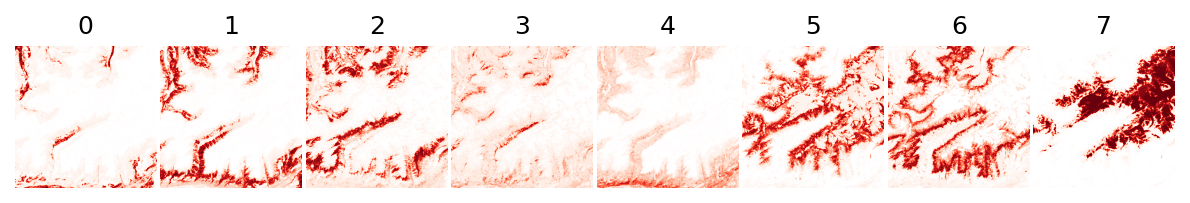

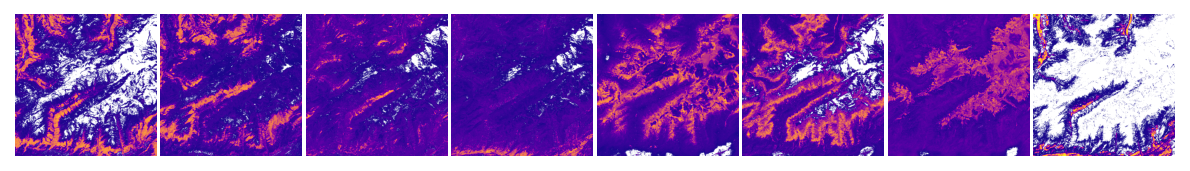

In [35]:
import numpy as np
from pyeumap.plotter import plot_rasters

lc_classes = [ int(c) for c in landmapper_eml.target_classes['transformed']]

plot_rasters(*output_fn_files[0:8], cmaps='Reds', titles=lc_classes)
plot_rasters(*output_fn_files[11:19], cmaps='plasma')

...and the dominant land cover:

Mapped land cover classes
 - 231 => pixel value 0 (red)
 - 312 => pixel value 1 (darkred)
 - 321 => pixel value 2 (springgreen)
 - 322 => pixel value 3 (green)
 - 324 => pixel value 4 (darkgreen)
 - 332 => pixel value 5 (yellow)
 - 333 => pixel value 6 (tan)
 - 335 => pixel value 7 (white)


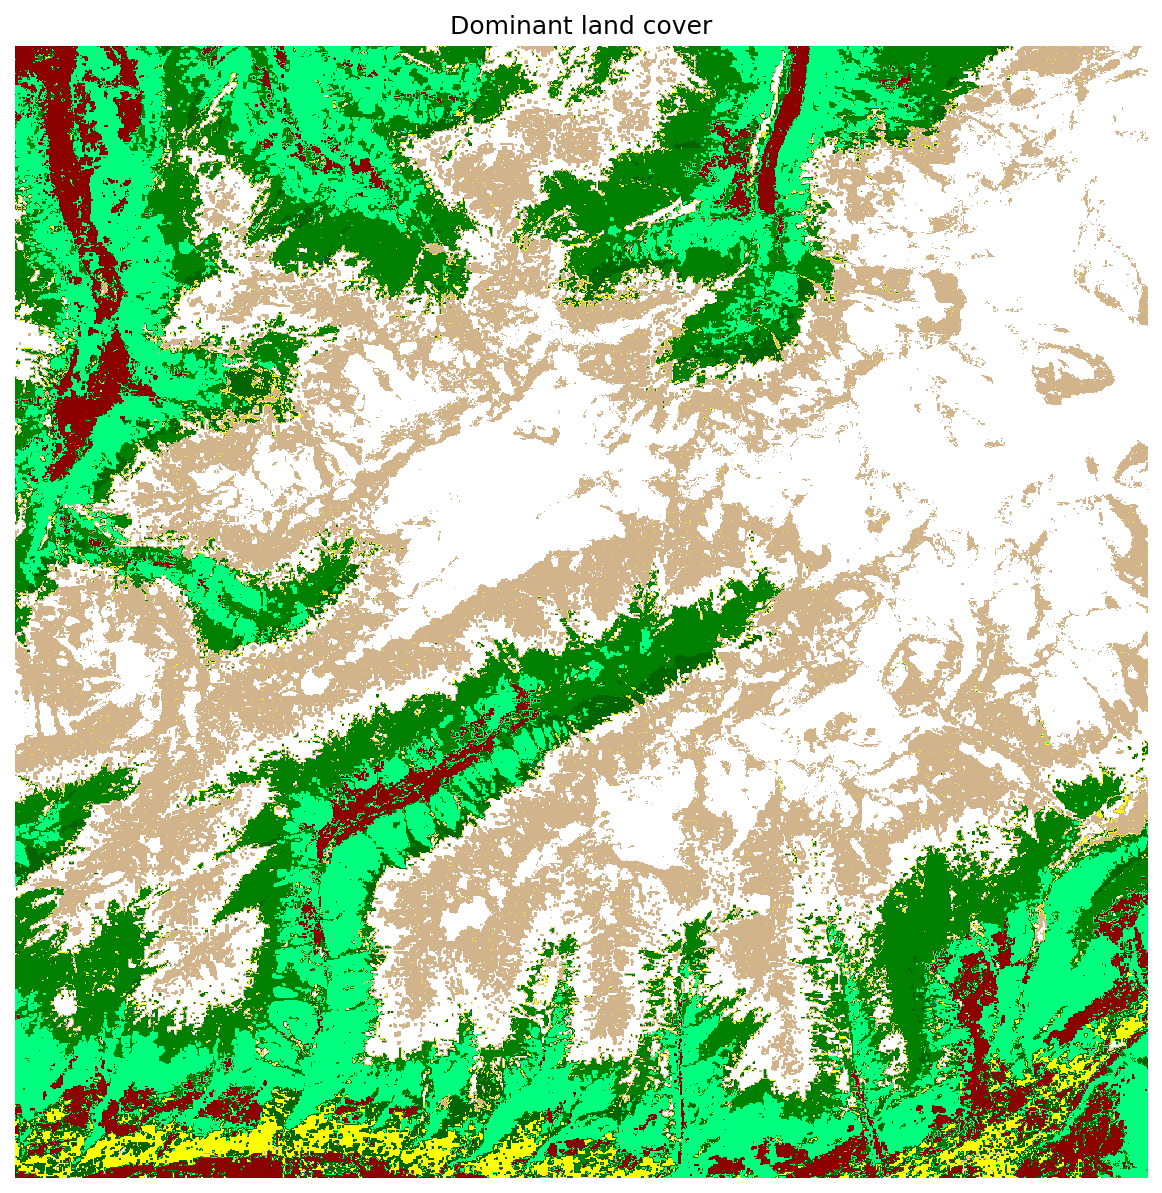

In [36]:
from pyeumap.plotter import plot_rasters
import numpy as np
from matplotlib.colors import ListedColormap

lc_classes = landmapper_eml.target_classes['original']
pixel_values = landmapper_eml.target_classes['transformed']
colors = ListedColormap(["red", "darkred", "springgreen", "green", "darkgreen", "yellow", "tan", "white"])

print("Mapped land cover classes")
for l, p, c in zip(lc_classes, pixel_values, colors.colors):
    print(f' - {l:.0f} => pixel value {p} ({c})')

plot_rasters(output_fn_files[8], cmaps = colors, titles = 'Dominant land cover')

Time to predict multiple years creating a list of **dirs_layers** and **fn_output** and passing to the method **predict_multi**, which will perform this task in parallel:

In [31]:
dir_timeless_layers = os.path.join(data_dir, 'timeless') 

dirs_layers_list = []
fn_output_list = []

for year in range(2000, 2003):
    dir_time_layers = os.path.join(data_dir, str(year))
    dirs_layers = [dir_time_layers, dir_timeless_layers]
    fn_result = os.path.join(data_dir, f'land_cover_eml_{year}.tif')
    
    dirs_layers_list.append(dirs_layers)
    fn_output_list.append(fn_result)

output_fn_files = landmapper_eml.predict_multi(dirs_layers_list=dirs_layers_list, fn_output_list=fn_output_list)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {Path(output_fn_file).name}')

[11:03:57] Reading 87 raster files
[11:04:02] 1) Reading time: 5.32 segs
[11:04:02] 1) Predicting 1000000 pixels
[11:04:02] Reading 87 raster files
[11:04:02] Executing RandomForestClassifier
[11:04:05] RandomForestClassifier prediction time: 2.77 segs
[11:04:05] Executing XGBClassifier
[11:04:07] XGBClassifier prediction time: 2.32 segs
[11:04:07] Executing Pipeline
[11:04:07] batch_size=500000
[11:04:08] 2) Reading time: 5.76 segs
[11:04:08] Reading 87 raster files
[11:04:11] Pipeline prediction time: 3.88 segs
[11:04:11] Executing LogisticRegression
[11:04:13] LogisticRegression prediction time: 1.39 segs
[11:04:13] 1) Predicting time: 10.40 segs
[11:04:13] 2) Predicting 1000000 pixels
[11:04:13] 3) Reading time: 5.41 segs
[11:04:13] Executing RandomForestClassifier
[11:04:14] 1) Saving time: 0.76 segs
[11:04:16] RandomForestClassifier prediction time: 2.68 segs
[11:04:16] Executing XGBClassifier
[11:04:18] XGBClassifier prediction time: 2.05 segs
[11:04:18] Executing Pipeline
[11:0

The ``LandMapper`` also supports a **eager** prediction strategy that *reads all the years*, run the predictions for all the data *at once* and write the output files:

In [34]:
from pyeumap.mapper import PredictionStrategyType

pred_strategy_type = PredictionStrategyType.Eager
output_fn_files = landmapper_eml.predict_multi(dirs_layers_list=dirs_layers_list, fn_output_list=fn_output_list, prediction_strategy_type=pred_strategy_type)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {Path(output_fn_file).name}')

[11:07:25] Reading 87 raster files[11:07:25] 
Reading 87 raster files
[11:07:25] Reading 87 raster files
[11:07:32] 2) Reading time: 6.61 segs
[11:07:32] 3) Reading time: 6.90 segs
[11:07:32] 1) Reading time: 6.92 segs
[11:07:33] 3) Predicting 3000000 pixels
[11:07:34] Executing RandomForestClassifier
[11:07:42] RandomForestClassifier prediction time: 8.36 segs
[11:07:42] Executing XGBClassifier
[11:07:47] XGBClassifier prediction time: 5.26 segs
[11:07:47] Executing Pipeline
[11:07:47] batch_size=1500000
[11:07:58] Pipeline prediction time: 10.61 segs
[11:07:58] Executing LogisticRegression
[11:08:01] LogisticRegression prediction time: 3.34 segs
[11:08:01] 3) Predicting time: 27.70 segs
[11:08:04] 3) Saving time: 2.27 segs
[11:08:04] 1) Saving time: 2.31 segs
[11:08:04] 2) Saving time: 2.37 segs
Output files:
 - land_cover_eml_2000_b1.tif
 - land_cover_eml_2000_b2.tif
 - land_cover_eml_2000_b3.tif
 - land_cover_eml_2000_b4.tif
 - land_cover_eml_2000_b5.tif
 - land_cover_eml_2000_b6.t

## Feature Selection

The ``LandMapper`` is fully compatible with scikit-learn, supporting any [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) and [Pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline) implementations. 

To demonstrate it, we will develop from scratch a simple **random feature selection strategy**, which will randomly reduce the number of input features before the training step.

In [37]:
from numpy.random import default_rng
from sklearn.base import BaseEstimator, TransformerMixin

class RandomFeatureSelector(TransformerMixin, BaseEstimator):

    def __init__(self, n_features = 10, seed = 0):
        self.n_features = n_features
        self.rng = default_rng()
        self.seed = seed

    def fit(self, X, y):
        n_features = X.shape[1]
        self.rand_features = self.rng.choice(n_features, size=self.n_features, replace=False)
        return self

    def transform(self, X):
        return X[:,self.rand_features]

Now let's define the expected **number of features** (*there are 87 features in total*), changing the input ``seed`` to produce diferent subsets. The ``passthrough`` will indicate to the pipeline just move foward to the next step.

In [60]:
feature_sel = [
    RandomFeatureSelector(n_features=60, seed = 0),
    RandomFeatureSelector(n_features=70, seed = 0),
    RandomFeatureSelector(n_features=80, seed = 0),
    RandomFeatureSelector(n_features=60, seed = 1),
    RandomFeatureSelector(n_features=70, seed = 1),
    RandomFeatureSelector(n_features=80, seed = 1),
    'passthrough'
]

This time we will define our estimators as [pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline), indicating the ``feature_sel`` step before them

In [61]:
estimator_rf = Pipeline([
    ('feature_sel', 'passthrough'),
    ('estimator', RandomForestClassifier(n_jobs=-1, max_depth=None,  n_estimators=85))
])

estimator_bgtree = Pipeline([
    ('feature_sel', 'passthrough'),
    ('estimator', xgb.XGBClassifier(n_jobs=-1, n_estimators=28, objective='multi:softmax', eval_metric='mlogloss', booster='gbtree'))
])

estimator_ann = Pipeline([
    ('feature_sel', 'passthrough'),
    ('standardize', StandardScaler()),
    ('estimator', KerasClassifier(build_ann, input_shape=input_shape, output_shape=n_classes, \
        epochs=5, batch_size=64, learning_rate = 0.0005, \
        dropout_rate=0.15, n_layers = 4, n_neurons=64, shuffle=True, verbose=False))
])

...and adding the ``feature_sel`` possibilities as a property in our hyperparameter optimization class (GridSearchCV):

In [62]:
hyperpar_rf = GridSearchCV(
    estimator = estimator_rf,
    scoring = log_loss_scorer,
    verbose = True,
    param_grid = {
     'feature_sel': feature_sel,
     'estimator__max_depth': [5, None], 
     'estimator__max_features': [0.5, None]
    }
)

hyperpar_bgtree = GridSearchCV(
    estimator = estimator_bgtree,
    scoring = log_loss_scorer,
    verbose = True,
    param_grid = {
     'feature_sel': feature_sel,
     'estimator__eta': [0.001, 0.9], 
     'estimator__alpha': [0, 10]
    }
)

hyperpar_ann = GridSearchCV(
    estimator = estimator_ann,
    scoring = log_loss_scorer,
    verbose = True,
    param_grid = {
     'feature_sel': feature_sel,
     'estimator__dropout_rate': [0, 0.15], 
     'estimator__n_layers': [2, 4]
    }
)

Let's keep the **same** meta-estimator

In [63]:
meta_estimator = LogisticRegression(solver='saga', multi_class='multinomial', C=1, fit_intercept=True)

... and ``LandMapper`` parameters:

In [65]:
feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'
weight_col = 'confidence'

min_samples_per_class = 0.05
cv = 2

landmapper_feat_sel = LandMapper(points=fn_points, 
                                feat_col_prfxs = feat_col_prfxs, 
                                target_col = target_col, 
                                estimator_list = [estimator_rf, estimator_bgtree, estimator_ann],
                                hyperpar_selection_list = [hyperpar_rf, hyperpar_bgtree, hyperpar_ann],
                                meta_estimator = meta_estimator,
                                min_samples_per_class = min_samples_per_class,
                                cv = cv,
                                pred_method='predict_proba',
                                verbose = True)

landmapper_feat_sel.train()

[11:51:49] Removing 74 samples due min_samples_per_class condition (< 0.05)
[11:51:49] Transforming lc_class:
[11:51:49]  -Original classes: [231. 312. 321. 322. 324. 332. 333. 335.]
[11:51:49]  -Transformed classes: [0 1 2 3 4 5 6 7]
[11:51:49] Optimizing hyperparameters for Pipeline
Fitting 2 folds for each of 28 candidates, totalling 56 fits
[11:52:15]  1.03380 (+/-0.00925) from {'estimator__max_depth': 5, 'estimator__max_features': 0.5, 'feature_sel': RandomFeatureSelector(n_features=60)}
[11:52:15]  1.07048 (+/-0.03043) from {'estimator__max_depth': 5, 'estimator__max_features': 0.5, 'feature_sel': RandomFeatureSelector(n_features=70)}
[11:52:15]  1.03688 (+/-0.00111) from {'estimator__max_depth': 5, 'estimator__max_features': 0.5, 'feature_sel': RandomFeatureSelector(n_features=80)}
[11:52:15]  1.06443 (+/-0.04619) from {'estimator__max_depth': 5, 'estimator__max_features': 0.5, 'feature_sel': RandomFeatureSelector(n_features=60, seed=1)}
[11:52:15]  1.02852 (+/-0.00671) from {'e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[11:56:55]  Meta-features shape: (1050, 24)
[11:56:55] Calculating evaluation metrics


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[11:56:56] Training Pipeline using all samples


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished


[11:56:56] Training Pipeline using all samples
[11:56:57] Training Pipeline using all samples
[11:57:00] Training meta-estimator using all samples


Checking the output it's possible to see that **some variables** were **removed**. 

How it impacted the accuracy metrics?

In [68]:
print(f'Log loss: {landmapper_feat_sel.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper_feat_sel.eval_report)

Log loss: 0.888


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  0.9243     0.8199   0.2467        0.7576              0.7576         66
1  0.7996     0.7615   0.4807        0.6884              0.6884         199
2  0.9565     0.7409   0.3756        0.7048              0.7048         166
3  1.5625     0.4514   0.2472        0.4741              0.4741         116
4  1.8263     0.2600   0.2341        0.2738              0.2738         84
5  0.7334     0.7849   0.3128        0.7624              0.7624         101
6  0.5294     0.8803   0.4810        0.8122              0.8122         229
7  0.2626     0.9780   0.6399        0.9438              0.9438         89

Total                                                                     1050



Even using less features in the estimator, the prediction needs receive the **full feature space** (*all rasters*), which will be reduced by the pipeline (``feature_sel`` step):

In [69]:
dir_timeless_layers = os.path.join(data_dir, 'timeless') 
dir_2000_layers = os.path.join(data_dir, '2000')

dirs_layers = [dir_2000_layers, dir_timeless_layers]
fn_output = os.path.join(data_dir, 'land_cover_eml_featsel_2000.tif')

output_fn_files = landmapper_feat_sel.predict(dirs_layers=dirs_layers, fn_output=fn_output)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {Path(output_fn_file).name}')

[12:04:36] Reading 87 raster files
[12:04:42] Executing Pipeline
[12:04:45] Pipeline prediction time: 3.17 segs
[12:04:45] Executing Pipeline
[12:04:48] Pipeline prediction time: 3.32 segs
[12:04:48] Executing Pipeline
[12:04:48] batch_size=500000
[12:04:52] Pipeline prediction time: 3.71 segs
[12:04:52] Executing LogisticRegression
[12:04:53] LogisticRegression prediction time: 1.27 segs
Output files:
 - land_cover_eml_featsel_2000_b1.tif
 - land_cover_eml_featsel_2000_b2.tif
 - land_cover_eml_featsel_2000_b3.tif
 - land_cover_eml_featsel_2000_b4.tif
 - land_cover_eml_featsel_2000_b5.tif
 - land_cover_eml_featsel_2000_b6.tif
 - land_cover_eml_featsel_2000_b7.tif
 - land_cover_eml_featsel_2000_b8.tif
 - land_cover_eml_featsel_2000_hcl.tif
 - land_cover_eml_featsel_2000_hcl_prob.tif
 - land_cover_eml_featsel_2000_uncertainty_b1.tif
 - land_cover_eml_featsel_2000_uncertainty_b2.tif
 - land_cover_eml_featsel_2000_uncertainty_b3.tif
 - land_cover_eml_featsel_2000_uncertainty_b4.tif
 - land

## VotingClassifier

Next, we will construct a EML using a [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html):

In [72]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

voting_eml = VotingClassifier([
    ('rf', RandomForestClassifier(n_jobs=-1, max_depth=None,  n_estimators=85)),
    ('svm', SVC(probability=True, cache_size=1024)),
    ('xgb', xgb.XGBClassifier(n_jobs=-1, n_estimators=28, objective='multi:softmax', eval_metric='mlogloss', booster='gbtree')),
], voting='soft')

hyperpar_voting_eml = GridSearchCV(
    estimator = voting_eml,
    scoring = log_loss_scorer,
    verbose = True,
    param_grid = {
     'svm__C': [1, 1.5],
     'svm__kernel': ['rbf', 'poly'],
     'xgb__eta': [0.001, 0.9], 
     'xgb__alpha': [0, 10],
     'rf__max_depth': [5, None], 
     'rf__max_features': [0.5, None]
    }
)

Time to train:

In [73]:
landmapper_vot = LandMapper(points=fn_points, 
                        feat_col_prfxs = feat_col_prfxs, 
                        target_col = target_col, 
                        estimator = voting_eml,
                        hyperpar_selection = hyperpar_voting_eml,
                        min_samples_per_class = min_samples_per_class,
                        cv = cv,
                        pred_method='predict_proba',
                        verbose = True)

landmapper_vot.train()

[12:05:40] Removing 74 samples due min_samples_per_class condition (< 0.05)
[12:05:40] Transforming lc_class:
[12:05:40]  -Original classes: [231. 312. 321. 322. 324. 332. 333. 335.]
[12:05:40]  -Transformed classes: [0 1 2 3 4 5 6 7]
[12:05:40] Optimizing hyperparameters for VotingClassifier
Fitting 2 folds for each of 64 candidates, totalling 128 fits
[12:08:15]  1.34466 (+/-0.00039) from {'rf__max_depth': 5, 'rf__max_features': 0.5, 'svm__C': 1, 'svm__kernel': 'rbf', 'xgb__alpha': 0, 'xgb__eta': 0.001}
[12:08:15]  0.95347 (+/-0.04395) from {'rf__max_depth': 5, 'rf__max_features': 0.5, 'svm__C': 1, 'svm__kernel': 'rbf', 'xgb__alpha': 0, 'xgb__eta': 0.9}
[12:08:15]  1.34456 (+/-0.00312) from {'rf__max_depth': 5, 'rf__max_features': 0.5, 'svm__C': 1, 'svm__kernel': 'rbf', 'xgb__alpha': 10, 'xgb__eta': 0.001}
[12:08:15]  1.12628 (+/-0.01795) from {'rf__max_depth': 5, 'rf__max_features': 0.5, 'svm__C': 1, 'svm__kernel': 'rbf', 'xgb__alpha': 10, 'xgb__eta': 0.9}
[12:08:15]  1.34731 (+/-0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[12:08:18] Training VotingClassifier using all samples


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s finished


... and check the accuracy:

In [74]:
print(f'Log loss: {landmapper_vot.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper_vot.eval_report)

Log loss: 0.870


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  0.8416     0.8290   0.3110        0.7727              0.7727         66
1  0.6672     0.7816   0.4818        0.7085              0.7085         199
2  0.9175     0.7894   0.3316        0.7229              0.7229         166
3  1.4939     0.5144   0.2285        0.5259              0.5259         116
4  1.9574     0.2976   0.1866        0.3333              0.3333         84
5  0.7807     0.8051   0.3334        0.7723              0.7723         101
6  0.5946     0.8946   0.3834        0.7991              0.7991         229
7  0.2311     0.9784   0.5772        0.9326              0.9326         89

Total                                                                     1050



# Saving/Loading the model(s)

For last, it's necessary to save the LandMapper instance, enabling to run **future predictions** without train the ML model(s) from scratch.

The method ``save_instance`` will do it for you using by default a [lz4](https://pypi.org/project/lz4/) compression:

In [30]:
fn_landmapper = os.path.join(data_dir, f'landmapper_eml.lz4')
landmapper_eml.save_instance(fn_landmapper)

It's also possible saves the instance removing the training data

In [20]:
fn_landmapper_thin = os.path.join(data_dir, f'landmapper_eml_thin.lz4')
landmapper_eml.save_instance(fn_landmapper_thin, no_train_data=True)

... and generating a smaller file:

In [39]:
from pathlib import Path
print("Model size:")
print(f' - {Path(fn_landmapper).stem}: {Path(fn_landmapper).stat().st_size / 1024 / 1024:.2f} MiB')
print(f' - {Path(fn_landmapper_thin).stem}: {Path(fn_landmapper_thin).stat().st_size / 1024 / 1024:.2f} MiB')

Model size:
 - landmapper_eml: 1.90 MiB
 - landmapper_eml_thin: 1.16 MiB


The ``*.h5`` refers to KerasClassifier ([more information here](https://stackoverflow.com/a/40397312)).